## Common Imports

In [51]:
import os
import math
import numpy as np
import pandas as pd
import plotly.express as px
from datetime import datetime
import plotly.graph_objects as go

from datetime import datetime

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import SparkSession

## Spark Session Initialization

In [52]:
Spark = SparkSession.builder \
    .appName("Aircraft Compliance Exploration") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.cores", "2") \
    .config("spark.executor.cores", "2") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.driver.host", "localhost") \
    .config("spark.driver.port", "4041") \
    .getOrCreate()

## Loading the data

In [53]:
file_path = 'case_study.csv'

if os.path.exists(file_path):
    df = Spark.read.csv(file_path, header=True, inferSchema=True)
    print("File loaded successfully.")
else:
    print("File not found.")

File loaded successfully.


## Examining the schema

In [54]:
df.printSchema()

root
 |-- date: date (nullable = true)
 |-- airport: string (nullable = true)
 |-- reference_number: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- departures: integer (nullable = true)
 |-- count_of_compliant_audit: integer (nullable = true)
 |-- count_of_audit: integer (nullable = true)



### Descriptive Statistics

In [55]:
# Get all numeric columns of type int or float
numeric_columns = [field.name for field in df.schema.fields
                   if isinstance(field.dataType, (T.StringType, T.IntegerType, T.FloatType, T.DoubleType))]

# Describe only those numeric columns
summary_stats = df.describe(numeric_columns)
summary_stats.show(truncate=False)

[Stage 56:===================>                                      (1 + 2) / 3]

+-------+----------+----------------+---------------+------------------+------------------------+-------------------+
|summary|airport   |reference_number|airline        |departures        |count_of_compliant_audit|count_of_audit     |
+-------+----------+----------------+---------------+------------------+------------------------+-------------------+
|count  |195625    |195625          |192509         |195625            |3562                    |195625             |
|mean   |0.0       |NULL            |NULL           |2211.8111028753992|0.9110050533408197      |1.0074479233226836 |
|stddev |0.0       |NULL            |NULL           |2346.550572697632 |0.7662475079537892      |0.09338934535799949|
|min    |#N/A      |Audit 1         |Mainline       |0                 |0                       |1                  |
|max    |Station 99|Audit 3         |United Airlines|8328              |7                       |8                  |
+-------+----------+----------------+---------------+---

## Feature Engineering

#### Temporal features such as 'year', 'month', 'day_of_week', 'quarter', 'is_weekend'. Alongwith cyclical encoding for 'month' and 'day_of_week'

In [56]:
def create_temporal_features(df):
    # Extract core temporal features
    df = df.withColumn("year", F.year("date")) \
           .withColumn("month", F.month("date")) \
           .withColumn("day_of_week", F.dayofweek("date")) \
           .withColumn("quarter", F.quarter("date")) \
           .withColumn("is_weekend", F.when(F.col("day_of_week").isin([1, 7]), 1).otherwise(0))
    return df

In [57]:
df = create_temporal_features(df)

#### Derived features: 'compliance_rate', 'audit_density' and 'compliance_per_departure'.

In [58]:
def create_derived_features(df):
    df = df.withColumn("compliance_rate",
                       F.when(F.col("count_of_audit") > 0,
                              (F.col("count_of_compliant_audit") / F.col("count_of_audit")).cast("double"))
                        .otherwise(0.0))
    df = df.withColumn("audit_density",
                       F.when(F.col("departures") > 0,
                              (F.col("count_of_audit") / F.col("departures")).cast("double"))
                        .otherwise(0.0))
    df = df.withColumn("compliance_per_departure",
                       F.when(F.col("departures") > 0,
                              (F.col("count_of_compliant_audit") / F.col("departures")).cast("double"))
                        .otherwise(0.0))
    return df

In [59]:
df = create_derived_features(df)

In [60]:
def handle_nan_inf(df):
    # Replace NaN, null, and infinite values with 0.0
    print(f"Original Dataframe: {df.count()}")
    df_processed = df.dropna()
    print(f"Processed Dataframe: {df_processed.count()}")
    return df_processed

In [61]:
# df = handle_nan_inf(df)

In [62]:
def create_cross_comparison_graph(df, date_col='date', filter_column='airline', filter_value='United Airlines', metric_cols='compliance_rate', start_date=None, end_date=None):
    """
    Cross-comparison of average metric values across audit groups (reference_number) and monthly time periods,
    with optional filtering by column and date range. Supports multiple metrics and automatically detects formatting
    for hover (percentage, int, float, etc.).

    Parameters:
    - df: PySpark DataFrame with the schema including 'date', 'reference_number', and the metric columns.
    - date_col: Column name for date (default: 'date').
    - filter_column: Column to filter on (e.g., 'airline'). If None, no filtering is applied.
    - filter_value: Value(s) to filter by (e.g., 'United Airlines' or ['United Airlines', 'Delta']). If None, no filtering is applied.
    - metric_cols: Column name(s) for the metrics to analyze (e.g., 'compliance_rate' or ['compliance_rate', 'another_metric']). Required.
    - start_date: Start date for filtering (format: 'YYYY-MM-DD' or None). If None, no start date filter is applied.
    - end_date: End date for filtering (format: 'YYYY-MM-DD' or None). If None, no end date filter is applied.
    """
    # Handle metric_cols as string or list
    if isinstance(metric_cols, str):
        metric_cols = [metric_cols]

    # Validate that reference_number, metric_cols, and date_col exist in DataFrame
    if 'reference_number' not in df.columns:
        raise ValueError("Column 'reference_number' not found in DataFrame")
    for metric in metric_cols:
        if metric not in df.columns:
            raise ValueError(f"Metric column '{metric}' not found in DataFrame")
    if date_col not in df.columns:
        raise ValueError(f"Date column '{date_col}' not found in DataFrame")

    # Apply filtering for filter_column and filter_value
    df_filtered = df
    if filter_column is not None and filter_value is not None:
        if filter_column in df.columns:
            if isinstance(filter_value, list):
                df_filtered = df_filtered.filter(F.col(filter_column).isin(filter_value))
            else:
                df_filtered = df_filtered.filter(F.col(filter_column) == filter_value)

    # Apply date range filtering if start_date or end_date is provided
    if start_date is not None:
        try:
            datetime.strptime(start_date, '%Y-%m-%d')  # Validate format
            df_filtered = df_filtered.filter(F.col(date_col) >= start_date)
        except ValueError:
            raise ValueError("start_date must be in 'YYYY-MM-DD' format or None")
    if end_date is not None:
        try:
            datetime.strptime(end_date, '%Y-%m-%d')  # Validate format
            df_filtered = df_filtered.filter(F.col(date_col) <= end_date)
        except ValueError:
            raise ValueError("end_date must be in 'YYYY-MM-DD' format or None")

    # Drop rows where any metric_col is null to ensure clean aggregation
    if metric_cols:
        for metric in metric_cols:
            df_filtered = df_filtered.filter(F.col(metric).isNotNull())

    # Aggregate average metric values by month and reference_number
    aggregated = df_filtered.groupBy(
        F.date_format(F.col(date_col), "yyyy-MM").alias("month"),
        "reference_number"
    ).agg(
        *(F.avg(F.col(metric)).alias(f"avg_{metric}") for metric in metric_cols)
    ).orderBy("month", "reference_number")

    # Convert to Pandas for Plotly
    pd_agg = aggregated.toPandas()

    # Melt the DataFrame for plotting multiple metrics
    pd_melt = pd.melt(
        pd_agg,
        id_vars=['month', 'reference_number'],
        value_vars=[f'avg_{metric}' for metric in metric_cols],
        var_name='avg_metric',
        value_name='avg_value'
    )
    pd_melt['metric'] = pd_melt['avg_metric'].str.replace('avg_', '')

    # Define title based on filtering
    title = "Cross Comparison of Average Metrics Across Audit Groups Over Time"
    if filter_column is not None and filter_value is not None:
        if isinstance(filter_value, list):
            title += f" ({', '.join(filter_value)})"
        else:
            title += f" ({filter_value})"
    if start_date is not None or end_date is not None:
        date_range = f"[{start_date or 'Start'} to {end_date or 'End'}]"
        title += f" {date_range}"

    # Create line plot with splines for time series comparison across audit groups
    fig = px.line(
        pd_melt,
        x="month",
        y="avg_value",
        color="reference_number",
        facet_row="metric",
        line_shape='spline',  # Use spline interpolation for smooth lines
        title=title,
        labels={
            "month": "Month (YYYY-MM)",
            "avg_value": "Average Value",
            "reference_number": "Audit Group",
            "metric": "Metric"
        },
        category_orders={"metric": metric_cols},  # Preserve metric order
        color_discrete_sequence=px.colors.sequential.Jet,
    )

    # Apply dark theme with black background
    fig.update_layout(
        template="plotly_dark",
        paper_bgcolor="black",
        plot_bgcolor="black",
        font_color="white",
        title_font_size=20,
        legend_title_font_color="white",
        legend_font_color="white",
        height=500,
    )

    # Rotate x-axis labels for better readability
    fig.update_xaxes(tickangle=45)

    # Automatically detect formats and update y-axes and hover templates per metric
    for i, metric in enumerate(metric_cols):
        col = f"avg_{metric}"
        vals = pd_agg[col].dropna()
        if len(vals) == 0:
            continue
        min_v = vals.min()
        max_v = vals.max()

        # Determine if percentage based on name or range
        name_lower = metric.lower()
        is_percentage = any(word in name_lower for word in ['rate', 'percent', 'pct', 'compliance', 'ratio', 'proportion']) or (min_v >= 0 and max_v <= 100)

        if is_percentage:
            if max_v <= 1.0001:
                hover_format = '.2%'
                y_label = f"Average {metric.replace('_', ' ').title()} (%)"
            else:
                hover_format = '.2f%'
                y_label = f"Average {metric.replace('_', ' ').title()} (%)"
        else:
            if all(abs(v - round(v)) < 1e-6 for v in vals):
                hover_format = '.0f'
                y_label = f"Average {metric.replace('_', ' ').title()}"
            else:
                hover_format = '.2f'
                y_label = f"Average {metric.replace('_', ' ').title()}"

        # Update y-axis label and hover template for this subplot row
        row_num = i + 1
        fig.update_yaxes(title_text=y_label, row=row_num, col=1)
        fig.update_traces(
            hovertemplate="Month: %{x}<br>Avg: %{y:" + hover_format + "}<br>Audit Group: %{trace.name}",
            row=row_num, col=1
        )

    # Show the figure
    fig.show()

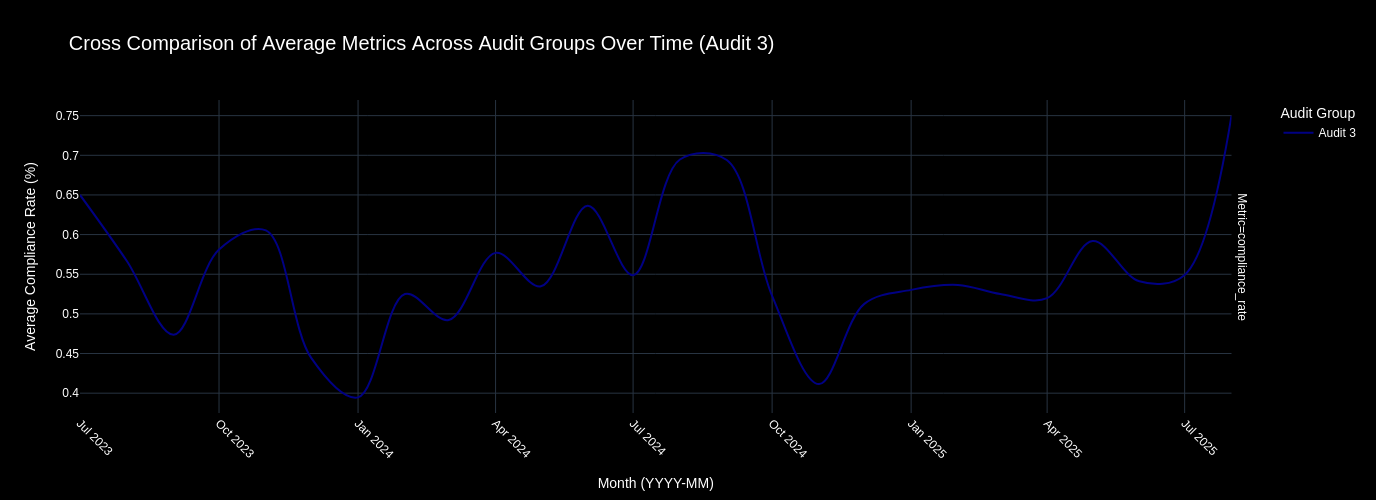

In [63]:
create_cross_comparison_graph(df, date_col='date', filter_column='reference_number', filter_value=['Audit 3'], metric_cols='compliance_rate', start_date=None, end_date=None)

In [174]:
preds = preds.withColumn(
    "prediction",
    F.when(F.col("prediction") < 0.0, 0.0)
     .when(F.col("prediction") > 1.0, 1.0)
     .otherwise(F.col("prediction"))
)